# Bayesian Parameter Estimation for α

In [13]:
import numpy as np
import pandas as pd
import scipy.special
import emcee
import multiprocessing as mp
import corner

import bokeh.io
import bokeh.plotting
import bokeh.themes
import bokeh.document

import pickle
bokeh.io.output_notebook()
cpus = mp.cpu_count()

Loading BokehJS ...

 In this notebook, I will write a Bayesian model for determination of the calibration factor $\alpha$, will test it out on some simulated data, and will then test it on some real data from Brewster et al. 2014.

## The Model 

Rather than binning the data t compute the calibration factor, I can perform a complete Bayesian regression for the parameter knowing my assumptions about the distribution of protein molecules. The crux of the model is that the intensity of one cell $I_1$ is related to the number of fluorescent protein molecules $N_1$ by a calibration $\alpha$ such that

$$
I_1 = \alpha N_1.
$$

It's important to note that the number of pretin molecules across a pair of daughter cells is conserved,

$$
N_{tot} = N_1 + N2 \Rightarrow N2 = N_{tot} - N_1.
$$

Therefore, the intensity is also conserved,

$$
I_{tot} = I_1 + I_2.
$$

Of course, there is lots of measurement error in the measurement of intensity. Using Bayes's rule, I can write down the posterior distribution I want to calculate as

$$
P(\alpha, \sigma, N_1, N_{tot}\, \vert \, I_1, I_2) \propto P(I_1, I_2 \, \vert \, \alpha, N_1, N_{tot})P(\alpha, \sigma, N_1, N_{tot}).
$$

Let's treat the likelihoods and priors with a little more rigor.

<br />
### Likelihoods 
There are really three likelihoods -- one for $I_1$, one for $I_2$, and one for $N_1$. We can make the assumption that the actual intensity measurements are gaussian distributed for each cell since there are a lot of processes that contribute to the the fluoresence of a single molecule. We can write the likelihoods for the two intensities $I_1$ and $I_2$ as

$$
P(I_1 \, \vert \, \alpha, \sigma, N_1, N_{tot}) = {1 \over \sqrt{2 \pi \sigma^2}}\exp\left[{-(I_1 - \alpha N_1)^2 \over 2 \sigma^2}\right]
$$

and

$$
P(I_2 \, \vert \, \alpha, \sigma, N_1, N_{tot}) = {1 \over \sqrt{2 \pi \sigma^2}}\exp\left[{-(I_2 - \alpha(N_{tot} - N_1))^2 \over 2\sigma^2}\right].
$$

We know that the actual protein partitioning across the two daughter cells should be Binomially distributed, allowing us to write the likelihood for $N_1$ as 

$$
P(N_1\, \vert N_{tot}, p) = {N_{tot}! \over N_1!(N_{tot} - N_1)!}p^{N_1}(1-p)^{N_{tot} - N_1}.
$$

If we make the assumption that partitioning between the two daughter cells is equal such that $p = 1/2$, the likelihood simplifies to

$$
P(N_1\, \vert N_{tot}) = {N_{tot}! \over N_1!(N_{tot} - N_1)!}\left({1 \over 2}\right)^{N_{tot}}.
$$

<br/>
### Priors

The priors are relatively simple for this case. We have separate priors for the calibration factor $\alpha$, $N_1$, and our uncertainty $\sigma$. It's fair to say that the priors for $\alpha$ and $N_1$ should be uniform, however the latter should be discrete uniform,

$$
P(\alpha) = \begin{cases}
{1 \over {\alpha_{max} - \alpha_{min}}},& \alpha_{min} \leq \alpha \leq \alpha_{max}\\
0 & \text{otherwise}
\end{cases}
$$

and 

$$
P(N_1) = \begin{cases}
{1 \over {N_{max} - N_{min}}}, & N_{min} \leq N_1 \leq N_{max}\\
0 &\text{otherwise}
\end{cases}.
$$

As $\sigma$ is a scale parameter, we can just simply use a Jeffrey's prior,

$$
P(\sigma) = {1 \over \sigma}.
$$

<br/>
### Full Posterior
Everything written so far is true for a *singele* cell division event. However, we will be looking over *many* cell division events to determine $\alpha$. We therefore need to adapt the likelihoods and priors written here to account for a the posterior for a full data set. We can just multiply the probailiteies together as they are simply independent,

$$
P(\alpha, \sigma, {N_{1,i}, N_{tot,i}}\,\vert\, {I_{1,i}, I_{2,i}}) =\\ {1 \over \sigma}\prod\limits_{i}^n{N_{tot,i}\choose{N_{1,i}}}2^{-N_{tot}}\left({1 \over \sqrt{2\pi\sigma^2}}\right)^n\exp\left[\left(-{1 \over 2\sigma^2}\right)^n\sum\limits_{i}^n \left(-(I_{1,i} - \alpha N_{1,i})^2 - (I_{2,i} - \alpha (N_{tot,i} - N_{1,i}))^2\right)\right].
$$

While complete, it's pretty gross. We can marginalize $\sigma$ to yield

$$
\begin{align}
P(\alpha, {N_{1,i}, N_{tot,i}}\,\vert\, {I_1, I_2}) &= \int\limits_0^\infty d\sigma P(\alpha, \sigma, {N_{1,i}, N_{tot,i}}\,\vert\, {I_{1,i}, I_{2,i}})\\
&=\prod\limits_i^{N_{tot,i}}{{N_{tot,i}}\choose{N_{1,i}}}2^{-N_{tot,i}}\exp\left[\sum\limits_i^n\left((I_{1,i} - \alpha N_{1,i})^2 + (I_{2,i} - \alpha(N_{tot,i} - N{1,i}))^2\right) \right]^{-n/2},
\end{align}
$$

by realizing that marginalizing $\sigma$ over a Gaussian distribution results in the Student-t distribution.

## Implementation  with MCMC

To test whether this approach is giving me the correct parameter values, I would like to try it on a sample data set where I **know** the value of $\alpha$. Back in June, I performed a realistic simulation of the dilution experiment where I introduced measurement noise into the value of $\alpha$. For that set I chose $\alpha = 150$ with a standard deviation of $10$ counts per molecule. Let's take a look at the squared intensity difference vs the sum. 

In [47]:
# Load the data. 
sim_data = pd.read_csv('../../data/other/simulated_dilution.csv')
sim_data['summed_int'] = sim_data['I_1'] + sim_data['I_2']
sim_data['squared_diff'] = (sim_data['I_1'] - sim_data['I_2'])**2

# Sample a small section of the data for computational simplicity. 
sim_data = sim_data.sample(500)
         
# Compute the theory line. 
I_tot = np.logspace(2, 7, 200)
alpha = sim_data['seeded_alpha'].unique()
theory = alpha * I_tot
    
# Set up the figure canvas
p = bokeh.plotting.figure(height=400, x_axis_label='summed intensity', 
                          y_axis_label='squared difference', 
                          x_axis_type='log', y_axis_type='log')

# Plot the points and theory.
p.scatter(x='summed_int', y='squared_diff', source=sim_data, color='slategrey', 
          alpha=0.4)
p.line(I_tot, theory, color='tomato', line_width=2,
       legend='α = {0} a.u. per molecule'.format(alpha[0]))
p.legend.location = 'top_left'
bokeh.io.show(p)

To perform the MCMC, we need to have a function to compute the log posterior. For clarity, I'll break this into three functions $-$ `log_prior` for the priors, `log_like` for the likelihood, and `log_post` which calls both. 

I need to impose actual values for the priors. As I showed up above, I'm assuming a uniform prior on both $\alpha$ and the protein copy number, meaning I have to settle on $max$ and $min$ values for each. 

For the bounds on $\alpha$, I can use some of my knowledge of the experiment. I know that I will be using a camera to make these measurements. I also know that I'll be careful not to overexpose my images. Therefore, I know that the calibration factor has to be in the range dictated by the bit depth of the camera. Assuming I use a fancy 16-bit EMCCD camera,  

$$
P(\alpha) = {1 \over \alpha_{max} - \alpha_{min}} = {1 \over (2^{16} - 1) - 0} = 65.535\times 10^{-3}.
$$


The protein copy number is a little bit more tricky as I have to figure out what the absolute maximum copy number could be for a cell. I know that the typical size of a protein is about $1\, \text{nm}^3 \approx 10^{-9}\, \text{fL}$. Approximating a standard *E. coli* cell as 1 fL bag of water, I could at absolute most fit $10^9$ proteins per cell, ignoring the fact that there are other things taking up the volume of the cell. Nevertheless, this seems like OK bound to use. My prior on $N$ is therefore,

$$
P(N_1) = {1 \over N_{max} - N_{min}} = {1 \over 10^9 - 0} = 10^{-9}.
$$

I've hard-coded these values into the `log_prior` function below. I will stick with "improper priors" are ignore them for the actual calculation of the log posterior.

In [125]:
def log_prior(p, n):
    """Priors for alpha, sigma, and protein copy numbers."""
    alpha = p[0]
    
    # Extract the protein copy numbers and convert to integer. 
    n1 = p[1:n+1].astype(int)
    ntot = p[n+1:].astype(int)
    
    # Apply the priors. 
    if (p < 0).any():
        return -np.inf
    if (n1 > n_tot).any():
        return -np.inf
    
    # Apply the hard-coded bounds.
    if alpha > 2**16 -1:
        return -np.inf
    if (n1 > 1E9).any() or (ntot > 1E9).any():
        return -np.inf
    
    # Compute the actual priors and return. 
    else:
        return np.log(1)

def log_like(p, I_1, I_2, n):
    """Computes the log likelihood."""
    
    # Unpack the parameters.
    alpha = p[0]
    n1 = p[1:n+1].astype(int)
    ntot = p[n+1:].atype(int)
    
    # Compute the log likelihood in sections so it's easier to return.   
    log_binom = -ntot.sum() * np.log(2) + scipy.special.gammaln(ntot + 1).sum() -\
                 scipy.special.gammaln(n1 + 1).sum() -\
                 scipy.special.gammaln(ntot - n1 + 1).sum()      
    log_norms = -(n/2)*np.log(((I_1 - alpha * n1)**2 +\
                (I_2 - alpha * (ntot - n1))**2).sum())
    return log_binom + log_norms

def log_post(p, I_1, I_2):
    """Combine the prior and likelihood for clarity"""
    n = len(I_1)
    n1 = p[1:n+1]
    ntot = p[n+1:]
    if (p < 0).any():
        return -np.inf
    if (n1 > ntot).any():
        return -np.inf
    else:
        return log_like(p, I_1, I_2, n)     

Now I can set up the parameters for the MCMC. 

In [126]:
# Define the various parameters of the MCMC.
num_div = len(sim_data)
n_burn = 500 # Number of burn-in steps. 
n_steps = 100 # Number of steps for each walker. 
n_dim = 2 * num_div + 1
n_walkers = 2 * n_dim + 2 

# Set the initial guesses and populate the starting positions. 
n_1 = sim_data['N_1']
n_tot = sim_data['N_1'] + sim_data['N_2']
p0 = np.empty((n_walkers, n_dim))
alpha=300
p0[:,0] = np.random.normal(alpha, scale=10, size=n_walkers)

# Ensure we start with N1 always less than Ntot
p0[:,1:num_div+1] = np.random.uniform(0, n_1*.01, size=(n_walkers, num_div))
p0[:,num_div+1:] = np.random.uniform(n_tot*.01, n_tot*.02, size=(n_walkers, num_div))

# Set up the sampler using threading. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,
                                args=(sim_data['I_1'], sim_data['I_2']), threads=cpus)

# Perform the burn-in and then sample. 
print('Beginning the burn-in...')
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
print('Finished! Now sampling....')
_ = sampler.run_mcmc(pos, n_steps, thin=100)
print('whew. That was rough. ')

Beginning the burn-in...


/opt/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/opt/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Finished! Now sampling....
whew. That was rough. 


In [127]:
# For safety, save the flatchain as a pickle
output = open('../../data/other/dilution_simulation_flatchain_delbruck.pkl', 'wb')
pickle.dump(sampler.flatchain, output)
pickle.dump(sampler.flatlnprobability, output)
output.close() # close it to make sure it's all been written

Since I have a shitload of parameters, I can't show the distribution for everything. However, I can plot the marginalized distribution for the posterior on $\alpha$. Rather than computing the mean and standard deviation, I'll opt to compute the mode and the credible region showing 95% of the sample density. 

In [128]:
# #################
def hpd(trace, mass_frac):
    """
    Returns highest probability density region given by
    a set of samples.
    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For hreple, `massfrac` = 0.95 gives a
        95% HPD.

    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD

    Notes
    -----
    We thank Justin Bois (BBE, Caltech) for developing this function.
    http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)

    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)

    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n - n_samples]

    # Pick out minimal interval
    min_int = np.argmin(int_width)

    # Return interval
    return np.array([d[min_int], d[min_int + n_samples]])


In [129]:
# Compute the histogram for the posterior distribution of alpha.
hist, edges = np.histogram(sampler.flatchain[:,0], bins=75)

# Compute the mode and HPD from the flatlnprob. 
ind = np.argmax(sampler.flatlnprobability)
mode = sampler.flatchain[ind,0]
cred_region = hpd(sampler.flatchain[:,0], 0.95)

# # Set up the figure
p = bokeh.plotting.figure(height=500, 
                          x_axis_label='calibration factor (a.u. per molecule)',
                          y_axis_label='posterior distribution',
                         tools="reset,hover,wheel_zoom,pan")
p.quad(top=hist, bottom=0, left=edges[1:], right=edges[:-1],
        fill_color='slategray', alpha=0.7, line_color='slategray')

p.ray(x=[mode], y=[0], length=0, angle=np.deg2rad(90), line_width=2, color='tomato',
     legend='mode')
p.ray(x=[cred_region[0]], y=[0], length=0, angle=np.deg2rad(90), line_width=2, color='dodgerblue',
     legend='credible region')
p.ray(x=[cred_region[1]], y=[0], length=0, angle=np.deg2rad(90), line_width=2, color='dodgerblue')
bokeh.io.show(p)

# Print the mode and HPD. 
print('The best estimate for calibration factor is {0:1.0f} +{2:1.0f} -{1:1.0f} a.u. per molecule'.format(
mode,  mode - cred_region[0], cred_region[1] - mode))

The best estimate for calibration factor is 295 +24 -14 a.u. per molecule


That seems pretty great! I get a mode right in the range of the expected $\alpha$ and the credible regions make a lot of sense.  

In [130]:
df = pd.DataFrame([sampler.flatchain[:,0], sampler.flatchain[:,1]]).T
df.columns=['alpha', 'sigma']

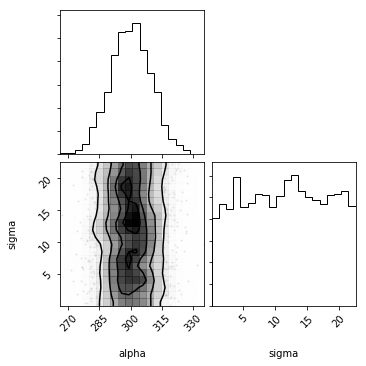

In [131]:
corner.corner(df, smooth=True)

In [133]:
np.unique(sampler.flatlnprobability)

array([-inf])

In [124]:
np.unique(np.exp(sampler.flatlnprobability))

array([ 0.])